## Import Packages

In [1]:
import os
from typing import List

import cv2
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelBinarizer
from torch import Tensor
from torch.utils.data import DataLoader, Dataset, random_split
from torch import save, load

## Define Device

In [2]:
device = "cpu"

In [21]:
import torch_directml
device = torch_directml.device()

In [3]:
print(device)

cpu


## Define Paths

In [12]:
base_dir = "../data/archive/"
csv_path = "../data/archive/hasy-data-labels.csv"

## Define Dataset

In [13]:
class LatexSymbolDataset(Dataset):
    def __init__(self, base_dir: str, csv_path: str):
        self.base_dir = base_dir
        self.df = pd.read_csv(csv_path)
        self.label_binarizer = LabelBinarizer()
        self.label_binarizer.fit(self.df['symbol_id'])

    def __len__(self) -> int:
        return self.df.shape[0]

    def __getitem__(self, index) -> (Tensor, Tensor):
        label = self.df.loc[index, "symbol_id"]
        path = self.df.loc[index, "path"]

        img_path = os.path.join(self.base_dir, path)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_tensor = torch.FloatTensor(img)[None, :, :]

        label_encoded = label_binarizer.transform([label])[0]
        label_tensor = torch.FloatTensor(label_encoded)
        
        return img_tensor, label_tensor

    def get_num_of_classes(self) -> int:
        return self.label_binarizer.classes_.shape[0]

## Define Model

In [14]:
class CNN(nn.Module):
    def __init__(self, in_channels: int, num_of_classes: int) -> None:
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=5),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(in_features=64 * 5 * 5, out_features=1024),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(in_features=1024, out_features=1024),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(in_features=1024, out_features=1024),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(1024, num_of_classes)
        )

        self.init_weights()

    def forward(self, x: Tensor) -> Tensor:
        return self.model(x)
    
    def init_weights(self):
        for module in self.model:
            if isinstance(module, nn.Conv2d):
                nn.init.xavier_uniform_(module.weight)

                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)

            elif isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)

## Define Helper Functions

In [15]:
def get_accuracy(y_pred: Tensor, y_train: Tensor) -> float:
    y_pred_index = torch.argmax(y_pred, 1)
    y_train_index = torch.argmax(y_train, 1)
    return (y_pred_index == y_train_index).sum().item() / y_pred.shape[0]

In [16]:
def print_statistics(epoch: int, batch: int, num_batches: int, loss: float, acc: float):
    print(f"EPOCH {epoch + 1} | BATCH {batch + 1} of {num_batches} | LOSS {loss:.4f} | ACCURACY {acc:.4f}")

In [17]:
def average_chunkwise(list: List[float], size: int, num_epochs: int) -> List[float]:
    return [sum(list[i * size: (i + 1) * size]) / size for i in range(num_epochs)]

## Setup Training

In [18]:
dataset = LatexSymbolDataset(base_dir, csv_path)

training_dataset, validation_dataset = random_split(dataset, [0.7, 0.3])

training_dataloader = DataLoader(training_dataset, batch_size=1000, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=1000, shuffle=True)

In [19]:
model = CNN(1, dataset.get_num_of_classes()).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

# collect stats
train_loss = []
train_acc = []
val_acc = []

## Perform Training

In [12]:
num_epochs = 30

for epoch in range(num_epochs):
    
    model.train()
    torch.enable_grad()
    print("TRAINING...")

    for index, (X_train, y_train) in enumerate(training_dataloader):
        # move to GPU
        X_train = X_train.to(device)
        y_train = y_train.to(device)

        # forward
        y_pred = model(X_train)
        loss = loss_function(y_pred, y_train)
        acc = get_accuracy(y_pred, y_train)

        # collect stats
        train_loss.append(loss.item())
        train_acc.append(acc)
        print_statistics(epoch, index, len(training_dataloader), loss.item(), acc)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    torch.no_grad()
    print("TESTING...")

    for index, (X_val, y_val) in enumerate(validation_dataloader):

        # move to GPU
        X_val = X_val.to(device)
        y_val = y_val.to(device)

        # forward
        y_pred = model(X_val)
        acc = get_accuracy(y_pred, y_val)

        # collect stats
        val_acc.append(acc)
        print_statistics(epoch, index, len(validation_dataloader), 0, acc)

TRAINING...
EPOCH 1 | BATCH 1 of 118 | LOSS 83.5047 | ACCURACY 0.0030
EPOCH 1 | BATCH 2 of 118 | LOSS 25.4256 | ACCURACY 0.0070
EPOCH 1 | BATCH 3 of 118 | LOSS 9.2283 | ACCURACY 0.0060
EPOCH 1 | BATCH 4 of 118 | LOSS 6.1910 | ACCURACY 0.0110
EPOCH 1 | BATCH 5 of 118 | LOSS 5.8226 | ACCURACY 0.0090
EPOCH 1 | BATCH 6 of 118 | LOSS 5.7572 | ACCURACY 0.0110
EPOCH 1 | BATCH 7 of 118 | LOSS 5.7567 | ACCURACY 0.0130
EPOCH 1 | BATCH 8 of 118 | LOSS 5.7407 | ACCURACY 0.0170
EPOCH 1 | BATCH 9 of 118 | LOSS 5.7961 | ACCURACY 0.0160
EPOCH 1 | BATCH 10 of 118 | LOSS 5.6985 | ACCURACY 0.0180
EPOCH 1 | BATCH 11 of 118 | LOSS 5.7042 | ACCURACY 0.0160
EPOCH 1 | BATCH 12 of 118 | LOSS 5.6999 | ACCURACY 0.0100
EPOCH 1 | BATCH 13 of 118 | LOSS 5.7242 | ACCURACY 0.0220
EPOCH 1 | BATCH 14 of 118 | LOSS 5.7265 | ACCURACY 0.0150
EPOCH 1 | BATCH 15 of 118 | LOSS 5.7260 | ACCURACY 0.0110
EPOCH 1 | BATCH 16 of 118 | LOSS 5.6900 | ACCURACY 0.0170
EPOCH 1 | BATCH 17 of 118 | LOSS 5.6728 | ACCURACY 0.0090
EPOCH 1 |

## Perform Evaluation

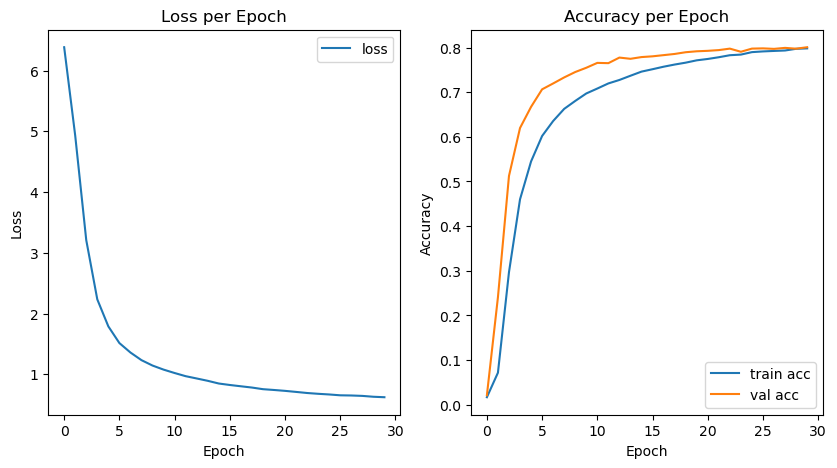

In [13]:
plt.figure(figsize=(10, 5))

trained_epochs = len(train_loss) // len(training_dataloader)
avg_train_loss = average_chunkwise(train_loss, len(training_dataloader), trained_epochs)
avg_train_acc = average_chunkwise(train_acc, len(training_dataloader), trained_epochs)
avg_val_acc = average_chunkwise(val_acc, len(validation_dataloader), trained_epochs)

plt.subplot(1, 2, 1)
plt.plot(avg_train_loss, label="loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(avg_train_acc, label="train acc")
plt.plot(avg_val_acc, label="val acc")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

plt.show()

## Save And Load Model

In [14]:
model = model.cpu()
with open('model_state.pt', 'wb') as f: 
        save(model.state_dict(), f)
model = model.to(device)

In [12]:
with open('model_state.pt', 'rb') as f: 
        model.load_state_dict(load(f))  